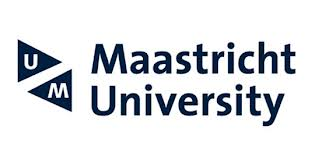
#Faculty of Science and Engineering - Department of Advanced Computer Sciences
# Course Advanced Natural Language Processing - Tutorial Deep Learning and NLP: BERT
By: Gijs Wijngaard

For this notebook we would need our GPU again (in the end). You can activate your GPU by clicking on *Runtime*, then *Change runtime type* and pressing *GPU*. If you hit the Google's GPU limits for usage, you can use other free GPU services such as [Kaggle GPU's ](https://kaggle.com/) (recommended), [Amazon's GPU's](https://studiolab.sagemaker.aws/) or [Paperspace Gradient](https://www.paperspace.com/gradient/notebooks) or of course your local GPU on your computer (if you have one).

#BERT and HuggingFace

So far, we have worked with a various amount of BERT models. BERT has a lot to offer:

a) pretrained models

b) bi-directional word embeddings

c) ability to deal with out-of vacabulairy words using sub-words (including byte pair enciding, byte-level byte pairing and the WordPiece tokenizer)

d) mask language modeling

e) next sentence prediction

Remember, there are 1000's of different BERT models, varying in size (different number of encoding layers L, different number of attention heads A, different number of hidden units H), and with different pre-training data.  



Hugging Face is an organization that is behind the very popular open-source library `transformers`. It is very useful and powerful for several NLP and NLU tasks. Transformers models work well when already pretrained, and the `transformers` library includes thousands of pre-trained models in about 100+ natural languages. Its ease of use and extendability is also a plus. You can run state-of-the-art models with just a few lines of code.

We can install `transformers` (and the `datasets` library) directly using pip as shown in the following: 


In [1]:
!pip install -qq transformers datasets

     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 451 kB 52.5 MB/s 
     |████████████████████████████████| 7.6 MB 43.6 MB/s 
     |████████████████████████████████| 182 kB 55.4 MB/s 
     |████████████████████████████████| 115 kB 55.0 MB/s 
     |████████████████████████████████| 212 kB 50.1 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 


Lets make sure we get the same results every time we run the same code in the notebook (reproducability). We can do this by setting the seeds of the packages we use. Like this:

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Vocabulary and Tokenizers

We can tokenize a piece of text by importing the tokenizer from the `transformers` library. Then to tokenize we use the `tokenize()` function. This function splits the texts based on the items in the vocabulary.

In [3]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT also has extra tokens involved, for example:

1. The classification token `[CLS]`. This token is for classification of the transformer. We attend to this token and we can take an embedding representation of a whole sentence by just using this token. 
2. The separation token `[SEP]`. This token is to let the model know we have separate sentences within a full text we pass to the model. 

In [4]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
tokenized_text

['[CLS]',
 'here',
 'is',
 'the',
 'sentence',
 'i',
 'want',
 'em',
 '##bed',
 '##ding',
 '##s',
 'for',
 '.',
 '[SEP]']

This text is not yet something we can pass through our model yet. For that, we need it converted to integers (ids). We can do this with the `convert_tokens_to_ids` function:

In [5]:
tokenizer.convert_tokens_to_ids(tokenized_text)

[101,
 2182,
 2003,
 1996,
 6251,
 1045,
 2215,
 7861,
 8270,
 4667,
 2015,
 2005,
 1012,
 102]

This function just looks up the tokens in the vocabulary. For example, the id 5000 means `knight`, because it is the 5000th index in the vocabulary:

In [6]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

We can convert ids back to tokens with the `convert_ids_to_tokens` function:

In [7]:
ids = tokenizer.convert_tokens_to_ids(tokenized_text)
tokenizer.convert_ids_to_tokens(ids)

['[CLS]',
 'here',
 'is',
 'the',
 'sentence',
 'i',
 'want',
 'em',
 '##bed',
 '##ding',
 '##s',
 'for',
 '.',
 '[SEP]']

Normally, we would just use `encode` or `encode_plus`. `encode` adds the `CLS` and `SEP`, add the `convert_tokens_to_ids` and `tokenize` steps into one step. `encode_plus` does this and also appends a `attention_mask` and `token_type_ids`. 

In [8]:
tokenizer.encode(text)

[101,
 2182,
 2003,
 1996,
 6251,
 1045,
 2215,
 7861,
 8270,
 4667,
 2015,
 2005,
 1012,
 102]

## BERT Models
In this section, we will learn how to extract embeddings from the pre-trained BERT. Consider the sentence 'I love Maastricht'. Let's see how to obtain the contextualized word embedding of all the words in the sentence using the pre-trained BERT model with Hugging Face's transformer library. 

Lets consider the `HuggingFace` library. We can check all the available pre-trained models [here](https://huggingface.co/models). For BERT, these models we can filter down on the `bert` [tag](https://huggingface.co/models?other=bert). For now, we use the [bert-base-uncased](https://huggingface.co/bert-base-uncased) model. As the name suggests, it a BERT with 12 encoders and it is trained with uncased tokens. The representation size will be 768. The `uncased` means that we have only lowercase letters in our tokenizer. 

We can download and load the pretrained model like this. Lets look how the model is implemented. Can you notice the 12 layers/encoders of the model? Also notice the different type of inputs we have in the embedding layer. The word embedding, that converts the token ids we have (30522 of them) into 768. Same holds for the position embeddings and the token_type_embeddings we could put in. 

In [9]:
model = BertModel.from_pretrained('bert-base-uncased')
model

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Preprocessing the input 
Define the sentence:

In [10]:
sentence = 'I love AI'

Tokenize the sentence and obtain the tokens:

In [11]:
tokens = tokenizer.tokenize(sentence)

Let's print the tokens:

In [12]:
print(tokens)

['i', 'love', 'ai']


Now, we will add the `[CLS]` token at the beginning and `[SEP]` token at the end of the tokens list: 

In [13]:
tokens = ['[CLS]'] + tokens + ['[SEP]']

Let's look at our updated tokens list:

In [14]:
print(tokens)

['[CLS]', 'i', 'love', 'ai', '[SEP]']


As we can observe, we have `[CLS]` token at the beginning and sep token at the end of our tokens list. We can also observe that length of our tokens is 5.

Say, we need to keep the length of our tokens list to 7, then, in that case, we will add two `[PAD]` tokens at the end as shown in the following:



In [15]:
tokens = tokens + ['[PAD]'] + ['[PAD]']

Let's print our updated tokens list:

In [16]:
print(tokens)

['[CLS]', 'i', 'love', 'ai', '[SEP]', '[PAD]', '[PAD]']




As we can observe, now we have the tokens list consists of `[PAD]` tokens and the length of our tokens list is 7. 

Next, we create the attention mask. The attention mask is there to let the model know which items should be taken into account when calculating the attentions. Since `[PAD]` tokens are just to pad the string and do not have any semantic meaning, we should let the model know not to take them into account. 

We set the attention mask value to 1 if the token is not a `[PAD]` token else we will set the attention mask to 0 as shown below:



In [17]:
attention_mask1 = [1 if i!= '[PAD]' else 0 for i in tokens]

Let's print the attention_mask:

In [18]:
print(attention_mask1)

[1, 1, 1, 1, 1, 0, 0]



As we can observe, we have attention mask values 0 at the position where have `[PAD]` token and 1 at other positions. 

Next, we convert all the tokens to their token_ids as shown below: 


In [19]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)


Let's have a look at the token_ids:

In [20]:
print(token_ids)

[101, 1045, 2293, 9932, 102, 0, 0]



From the above output, we can observe that each token is mapped to a unique token id.

Now, we convert the token_ids and attention_mask to tensors as shown below:

In [21]:
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask1 = torch.tensor(attention_mask1).unsqueeze(0)


That's it. Next, we feed the token_ids and attention_mask to the pre-trained BERT model and get the embedding. 

## Getting the embedding 

As shown in the following code, we feed the token_ids, and attention_mask to the model and get the output of the model:

In [22]:
print(token_ids)
print(attention_mask1)
last_hidden_state, pooler_output = model(token_ids, attention_mask = attention_mask1).to_tuple()

tensor([[ 101, 1045, 2293, 9932,  102,    0,    0]])
tensor([[1, 1, 1, 1, 1, 0, 0]])


This output contains two keys or more keys, depending on the task at hand. In the case of `bert-base-uncased`, we get 

In [23]:
last_hidden_state.shape, pooler_output.shape

(torch.Size([1, 7, 768]), torch.Size([1, 768]))

The `pooler_output` is basically the `last_hidden_state`'s `[CLS]` token through the pooling module (linear layer + activation) at the end:

In [24]:
torch.allclose(pooler_output, model.pooler(last_hidden_state))

True

The size `[1,7,768]` indicates the `[batch_size, sequence_length, hidden_size]`.

Our batch size is 1, the sequence length is the token length, since we have 7 tokens, the sequence length is 7, and the hidden size is the representation (embedding) size and it is 768 for the BERT-base model. 

We can obtain the representation of each token as: 

- `output.last_hidden_state[0][0]` gives the representation of the first token which is `[CLS]`
- `output.last_hidden_state[0][1]` gives the representation of the second token which is 'I' 
- `output.last_hidden_state[0][2]` gives the representation of the third token which is 'love'.

We can also index it with `output.last_hidden_state[:, 0, :]`. In this way, we specify that we want to have the zeroth element on the second index, we get a matrix in return with both the batch size and the embedding size (since we put a colon there).

In this way, we can obtain the contextual representation of all the tokens. This is basically the contextualized word embeddings of all the words in the given sentence. 

### Exercise 1
1. Now write your own code. Put the following text (the one defined under here with three times `bank` in it) to the tokenizer, add `[CLS]` and `[SEP]` values to it and pass it through the model. Get the vector representations of each of the three tokens of `bank` in the sentence and compare them. 
2. How does this differ from putting the text through a Word2Vec model? 
2. Put a string with only "bank" (add `[CLS]` and `[SEP]`) through the tokenizer and model. How does this vector of the word "bank" differ from the other "bank" vectors?

WRITE YOUR ANSWER HERE
1.All the three vectors are different.After calculationg the cos similarity for the first two 'bank' words we find high similarity(95%) as they have similar meaning..and not high similarity(70%) for the 'bank' words with the different meaning.
2.Word2Vec models generate embeddings that are context-independent.It will generate the same single vector for all the three words 'bank'. Whereas, BERT will generate different vectors for the word bank being used in different contexts.
3.The vector totally differs from the other vectors.The cos similarity indicates that the word meaning is different from both other meanings of the word 'bank'.

In [25]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."
# WRITE YOUR CODE HERE
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)
model.eval()
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
print(outputs[0][0][6][0:5])
print(outputs[0][0][19][0:5])
print(outputs[0][0][10][0:5])

from scipy.spatial.distance import cosine
diff_bank = 1 - cosine(outputs[0][0][6], outputs[0][0][19])
same_bank = 1 - cosine(outputs[0][0][6], outputs[0][0][10])
print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)
text2= "[CLS] " + 'bank' + " [SEP]"
marked_text2 = "[CLS] " + text2 + " [SEP]"
tokenized_text2 = tokenizer.tokenize(marked_text2)
indexed_tokens2 = tokenizer.convert_tokens_to_ids(tokenized_text2)
segments_ids2 = [1] * len(tokenized_text2)
tokens_tensor2 = torch.tensor([indexed_tokens2])
segments_tensors2 = torch.tensor([segments_ids2])
for i, token_str in enumerate(tokenized_text2):
  print (i, token_str)
with torch.no_grad():

    outputs2 = model(tokens_tensor2, segments_tensors2)
    hidden_states2 = outputs2[2]
print(outputs2[0][0][2][0:5])
print(1 - cosine(outputs[0][0][6], outputs2[0][0][2]))
print(1 - cosine(outputs[0][0][19], outputs2[0][0][2]))

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([ 0.9001, -0.5380, -0.1669,  0.2242,  0.6897])
tensor([ 0.2961, -0.2856, -0.0382,  0.1674,  0.7713])
tensor([ 0.7977, -0.5217, -0.1984,  0.1890,  0.5941])
Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.70
0 [CLS]
1 [CLS]
2 bank
3 [SEP]
4 [SEP]
tensor([-0.3942, -0.8264, -0.5570, -0.5478,  0.4285])
0.36390575766563416
0.376626580953598


In [26]:
#Second method summing the last 4 layers
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."
# WRITE YOUR CODE HERE
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)
model.eval()
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()
## creating the word vectors by summing together the last four layers
token_vecs_sum = []
for token in token_embeddings:

    sum_vec = torch.sum(token[-4:], dim=0)
    
    token_vecs_sum.append(sum_vec)
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)
###we will see at which indices are the words bank and use it later:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))
#the values differ, but let’s calculate the cosine similarity between the vectors to make a more precise comparison
from scipy.spatial.distance import cosine
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

text2= "[CLS] " + 'bank' + " [SEP]"
marked_text2 = "[CLS] " + text2 + " [SEP]"
tokenized_text2 = tokenizer.tokenize(marked_text2)
indexed_tokens2 = tokenizer.convert_tokens_to_ids(tokenized_text2)
segments_ids2 = [1] * len(tokenized_text2)
tokens_tensor2 = torch.tensor([indexed_tokens2])
segments_tensors2 = torch.tensor([segments_ids2])
with torch.no_grad():

    outputs2 = model(tokens_tensor2, segments_tensors2)
    hidden_states2 = outputs[2]
token_embeddings2 = torch.stack(hidden_states2, dim=0)
token_embeddings2 = torch.squeeze(token_embeddings2, dim=1)
token_embeddings2 = token_embeddings.permute(1,0,2)
## creating the word vectors by summing together the last four layers
token_vecs_sum2 = []
for token in token_embeddings2:

    sum_vec2 = torch.sum(token[-4:], dim=0)
    
    token_vecs_sum2.append(sum_vec2)
for i, token_str in enumerate(tokenized_text2):
  print (i, token_str)
print("bank ", str(token_vecs_sum2[2][:5]))
x=1 - cosine(token_vecs_sum[10], token_vecs_sum2[2])
print(x)
y=1 - cosine(token_vecs_sum[19], token_vecs_sum2[2])
print(y)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]
First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])
Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
0 [CLS]
1 [CLS]
2 bank
3 [SEP]
4 [SEP]
bank  tensor([ 1.1046,  0.5003, -2.3397, -0.5228, -0.0349])
0.44108402729034424
0.5723540782928467


# Extracting embeddings from all encoder layers of BERT
We learned how to extract the embedding from the pre-trained BERT in the previous section. We learned that they are the embeddings obtained from the final encoder layer. Now the question is should we consider the embedding obtained only from the final encoder layer (final hidden state), or should we also consider the embedding obtained from all the encoder layers (all hidden states)? Let's explore more about this. 

Instead of taking the embeddings (representation) only from the final encoder layer, the researchers of the BERT have experimented with taking embeddings from different encoder layers.

For instance, for a named-entity recognition task, the researchers have used the pre-trained BERT for extracting features. Instead of using the embedding only from the final encoder layer (final hidden layer) as a feature, they have experimented using embedding  from other encoder layers (other hidden layers) as a feature and obtained the following F1 score: 
<a name="table"></a>
$$
\begin{array}{lll}
\textbf{Feature}                 & \textbf{Notation} & \textbf{F1 score} \\ \hline
\text{Embeddings}                       & h_0              & 91.0             \\
\text{Second to last hidden}            & h_{11}         & 95.6             \\
\text{Last hidden}                      & h_{12}         & 94.9             \\
\text{Sum of last four hidden} & h_9\text{ to }h_{12} & 95.9             \\
\text{Concat last four hidden}          & h_9\text{ to }h_{12} & 96.1             \\
\text{Sum of all 12 layers}     & h_1\text{ to }h_{12} & 95.5            
\end{array}
$$

As we can observe from the preceding table, concatenating the embeddings of the last 4 encoder layers (last 4 hidden layers) gives us a greater F1 score of 96.1% in the  NER task. Thus, instead of taking the embeddings only from the final encoder layer (final hidden layer), we can also use embeddings from the other encoder layers.

Now, we will learn how to extract the embeddings from all the encoder layers using the transformers library. 

## Extracting the embeddings 
First, let us import the necessary modules: 

In [27]:
from transformers import BertModel, BertTokenizer
import torch


Next, download the pre-trained BERT model and tokenizer. As we can notice while downloading the pre-trained BERT model. We need to set `output_hidden_states= True`. By setting this to true helps us to obtain embeddings from all the encoder layers: 


In [28]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Next, we preprocess the input before feeding it to the model. 

## Preprocess the input
Let's consider the same sentence we saw in the previous section. First, we tokenize the sentence and add [CLS] token at the beginning and [SEP] token at the end: 


In [29]:
sentence = 'I love AI'
tokens = tokenizer.tokenize(sentence)
tokens = ['[CLS]'] + tokens + ['[SEP]']


Suppose, we need to keep the token length to 7. So, we add the [PAD] tokens and also define the attention mask: 

In [30]:
tokens = tokens + ['[PAD]'] + ['[PAD]']
attention_mask = [1 if i!= '[PAD]' else 0 for i in tokens]


Next, we convert the tokens to their token_ids:

In [31]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)




Now, we convert the token_ids and attention_mask to tensor: 

In [32]:
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)



Now that we preprocessed the input, let's get the embedding. 

## Getting the embedding 
Since we set `output_hidden_states = True` while defining the model for getting the embeddings from all the encoder layers, now the model returns an output tuple with three values as shown below:


In [33]:
last_hidden_state, pooler_output, hidden_states = model(token_ids, attention_mask = attention_mask).to_tuple()
last_hidden_state.shape

torch.Size([1, 7, 768])

Again, the first value `last_hidden_state` contains the representation of all the tokens obtained only from the final encoder layer (encoder 12). 

The `pooler_output` indicates the representation of the [CLS] token from the final encoder layer which is further processed by a linear and tanh activation function. 

`hidden_states` contains the representation of all the tokens obtained from all the final encoder layers. Lets look at this last one now specifically.


In [34]:
len(hidden_states)

13


As we can notice, it contains 13 values holding the representation of all layers. Thus: 

- hidden_states[0] contains the representation of all the tokens obtained from the input embedding layer 
- hidden_states[1] contains the representation of all the tokens obtained from the first encoder layer 
- hidden_states[2] contains the representation of all the tokens obtained from the second encoder layer 

Similarly, hidden_states[12] contains the representation of all the tokens obtained from the final encoder layer 
Let's explore this more. First, let's print the shape of the hidden_states[0] which contains the representation of all the tokens obtained from the input embedding layer : 


In [35]:
hidden_states[0].shape

torch.Size([1, 7, 768])


The size [1,7,768] indicates the[batch_size, sequence_length, hidden_size].

Now, let's print the shape of hidden_states[1] which contains the representation of all tokens obtained from the first encoder layer : 


In [36]:
hidden_states[1].shape

torch.Size([1, 7, 768])

### Exercise 2
Write down each of the 6 feature vectors from the [table](#table) in this section above only from the `hidden_states` of your model. Define one variable for each.

In [37]:
### CODE HERE
h0=hidden_states[0]
print(h0)
h11=hidden_states[11]
print(h11)
h12=hidden_states[12]
print(h12)
h912=0
for i in range(9,13):
  h912=h912+hidden_states[i]
print(h912)
con=torch.cat((hidden_states[9],hidden_states[10],hidden_states[11],hidden_states[12]),dim=0)
print('concatenated :'     ,con)
h112=0
for i in range(1,13):
  h112=h112+hidden_states[i]
print(h112)



tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.4027e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [ 1.1558e+00,  8.5331e-02, -1.1208e-01,  ...,  4.3965e-01,
           8.5903e-01, -3.2685e-01],
         ...,
         [-3.6430e-01, -1.6172e-01,  9.0174e-02,  ..., -1.7849e-01,
           1.2818e-01, -4.5116e-02],
         [ 1.6776e-01, -8.9038e-01, -3.1798e-01,  ...,  3.1737e-02,
           6.4863e-02,  1.8418e-01],
         [ 3.5675e-01, -8.7076e-01, -3.7621e-01,  ..., -7.9391e-02,
          -1.0115e-01,  1.9312e-01]]], grad_fn=<NativeLayerNormBackward0>)
tensor([[[ 0.1564,  0.1812, -0.0396,  ..., -0.1892, -0.2133,  0.0925],
         [ 0.6407,  0.2842,  0.3854,  ..., -0.4780,  0.1137,  0.4909],
         [ 0.8315,  0.8067,  0.8561,  ..., -0.8456,  0.6180, -0.2557],
         ...,
         [-0.0046,  0.0040, -0.0063,  ...,  0.0208, -0.0392,  0.0214],
         [ 0.5338,  

# Finetuning BERT for sentiment analysis 

Let's learn how to finetune the pre-trained BERT for text classification tasks. Say, we are performing sentiment analysis. In the sentiment analysis, our goal is to classify whether a sentence is positive or negative. Suppose, we have a dataset containing sentences along with their labels. 

Consider a sentence: `I love AI`. First, we tokenize the sentence, add the `[CLS]` token at the beginning, and `[SEP]` token at the end of the sentence. Then, we feed the tokens as an input to the pre-trained BERT and get the embeddings of all the tokens. 

Next, we ignore the embedding of all other tokens and take only the embedding of `[CLS]` token which is $R_{[CLS]}$. The embedding of the `[CLS]` token will hold the aggregate representation of the sentence. We feed $R_{[CLS]}$ to a classifier (feed-forward network with softmax function) and train the classifier to perform sentiment analysis. 

Wait! How does it differ from what we saw at the beginning of the section. How finetuning the pre-trained BERT differs from using the pre-trained BERT as a feature extractor?

In the first section, we learned that after extracting the embedding $R_{[CLS]}$ of a sentence, we feed the $R_{[CLS]}$ to a classifier and train the classifier to perform classification. Similarly, during finetuning, we feed the embedding of $R_{[CLS]}$ to a classifier and train the classifier to perform classification.

The difference is that when we finetune the pre-trained BERT, we can update the weights of the pre-trained BERT along with a classifier. But when we use the pre-trained BERT as a feature extractor, we can update only the weights of a classifier and not the pre-trained BERT. 

During finetuning, we can adjust the weights of the model in the following two ways:

- Update the weights of the pre-trained BERT along with the classification layer 
- Update only the weights of the classification layer and not the pre-trained BERT. When we do this, it becomes the same as using the pre-trained BERT as a feature extractor

The following figure shows how we finetune the pre-trained BERT for the sentiment analysis task:


As we can observe from the preceding figure, we feed the tokens to the pre-trained BERT and get the embedding of all the tokens. We take the embedding of `[CLS]` token and feed it to a feedforward network with a softmax function and perform classification. 

Let's get a better understanding of how finetuning works by getting hands-on with finetuning the pre-trained BERT for sentiment analysis in the next section. 



Import the necessary modules: 

In [38]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch
import numpy as np


Load the model and dataset. First, let's download and load the dataset using the `datasets` library. We only take the first 20 percent from the training set and the first 5 percent from the test set, otherwise the training will take too long.

In [39]:
from datasets import load_dataset
train_set = load_dataset("imdb", split="train[:25%]")
test_set = load_dataset("imdb", split="test[:10%]")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.



Let's print the dataset:

In [40]:
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 6250
})

And the test set:

In [41]:
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})


Next, let's download and load the pre-trained BERT model. In this example, we use the pre-trained bert-base-uncased model. As we can observe below, since we are performing sequence classification, we use the BertForSequenceClassification class: 


In [42]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Next, we download and load the tokenizer which is used for pretraining the bert-base-uncased model.
As we can observe, we create the tokenizer using the BertTokenizerFastclass instead of BertTokenizer. The BertTokenizerFast class has many advantages compared to BertTokenizer. We will learn about this in the next section: 


In [43]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]


Now that we loaded the dataset and model, next let's preprocess the dataset. 

## Preprocess the dataset
We can preprocess the dataset in a quicker way using our tokenizer. For example, consider the sentence: 'I love AI'.  

First, we tokenize the sentence and add the `[CLS]` token at the beginning and `[SEP]` token at the end as shown below: 


```
tokens = [ [CLS], I, love, AI, [SEP] ]
```


Next, we map the tokens to the unique input ids (token ids). Suppose the following are the unique input ids (token ids):


```
input_ids = [101, 1045, 2293, 3000, 102]
```

Then, we need to add the segment ids (token type ids). Wait, what are segment ids? Suppose we have two sentences in the input. In that case, segment ids are used to distinguish one sentence from the other. All the tokens from the first sentence will be mapped to 0 and all the tokens from the second sentence will be mapped to 1. Since here we have only one sentence, all the tokens will be mapped to 0 as shown below:


```
token_type_ids = [0, 0, 0, 0, 0]
```


Now, we need to create the attention mask. We know that an attention mask is used to differentiate the actual tokens and `[PAD]` tokens. It will map all the actual tokens to 1 and the `[PAD]` tokens to 0. Suppose, our tokens length should be 5. Now, our tokens list has already 5 tokens. So, we don't have to add `[PAD]` token. Then our attention mask will become: 


```
attention_mask = [1, 1, 1, 1, 1]
```


That's it. But instead of doing all the above steps manually, our tokenizer will do these steps for us. We just need to pass the sentence to the tokenizer as shown below:


In [44]:
tokenizer('I love AI')

{'input_ids': [101, 1045, 2293, 9932, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}


With the tokenizer, we can also pass any number of sentences and perform padding dynamically. To do that, we need to set padding to True and also the maximum sequence length. For instance, as shown below, we pass three sentences and we set the maximum sequence length, max_length to 5:


In [45]:
tokenizer(['I love AI', 'birds fly','snow fall'], padding = True, max_length=5)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2323: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


{'input_ids': [[101, 1045, 2293, 9932, 102], [101, 5055, 4875, 102, 0], [101, 4586, 2991, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]}


That's it, with the tokenizer, we can easily preprocess our dataset. So we define a function called preprocess for processing the dataset as shown below: 


In [46]:
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)


Now, we preprocess the train and test set using the preprocess function. The dataset loader still shows 0/1 when its done, its a known [bug](https://github.com/huggingface/datasets/issues/5117) in the library. Your dataset is still preprocessed.

In [47]:
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(train_set))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
train_set[0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

That's it. Now that we have the dataset ready, let's train the model. 

## Training the model 


Define the batch size and epoch size.

Batch size is how many items we put in per loop. So a batch size of 8 means 8 items per rendering. We need to do this because of the memory allocation of the GPU, its impossible to do the whole dataset at once, because this otherwise wouldn't fit in the GPU.

The number of epochs is how many times we loop over the whole dataset.

In [49]:
batch_size = 8
epochs = 1


Define the warmup steps and weight decay.

Warmup steps means that in the beginning of training we set the learning to a really slow amount (slow learning rate). We let our network components kind of get used to our dataset, before we really move a lot in our optimization. 

We use weight decay to avoid overfitting by adding a penalty to our training function.



In [50]:
warmup_steps = 500
weight_decay = 0.01

Lets first define what metrics we want to compute. We deal with binary classification, so it makes sense to include precision, recall, f1 and accuracy.

In [51]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1.item(), 'precision': precision.item(), 'recall': recall.item()}

This is how you would define your training loop in the `transformers` library: We can put things in like the number of training epochs, batch size, warmup steps and weight decay. Now lets define the training arguments:

In [52]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./logs',
)



Now define the trainer: 

In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=test_set
)

Start training the model. The training takes about 10 minutes in total!

Please make sure you are on GPU, otherwise this takes even longer.

In [54]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6250
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 782
  Number of trainable parameters = 109483778


Step,Training Loss


KeyboardInterrupt: ignored


After training we can evaluate the model using the evaluate function:

In [ ]:
trainer.evaluate()

### Exercise 3
1. Instead of using the `Trainer` function from the `transfomers` library, now write your own training loop using **only PyTorch**. You should also implement weight decay and use a linear scheduler. Train for 1 epoch.
2. Write an evaluation loop on your test data. Implement `f1`, `accuracy`, `precision` and `recall` and evaluate your model. 

In [ ]:
## CODE HERE
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.train()
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr=1e-5)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_set) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_set, batch_size=8)
for batch in train_dataloader:
  encoding = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
  input_ids = encoding['input_ids']
  attention_mask = encoding['attention_mask']
  labels = torch.tensor([1,0]).unsqueeze(0)
  outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
  loss = outputs[0]
  loss.backward()
  optimizer.step()
  scheduler.step()        
  optimizer.zero_grad()


In [ ]:
model.eval()
predictions , true_labels = [], []
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

compute_metrics(true_labels,predictions)


# Fine-tuning Pretrained Transformers for Named Entity Recognition

In the previous section we worked on sentiment prediction with just two classes using BERT. In this notebook we'll be using BERT-based models for Named Entity Recognition. Again, exactly the same model, but now we train it for a different dataset. Lets see if we can tag some sentences.

One thing to notice is that we now have a different class type within Bert that we going to use. Notice that instead of BertForSequenceClassification we now use BertForTokenClassification. The former we use for predicting labels from a whole piece of text (e.g. sentences). Now we want to classify per token basis. 

We should reimport the model first, otherwise it is still finetuned on the previous task. That knowledge does not make sense anymore for this task.

In [ ]:
from transformers import BertForTokenClassification, AutoTokenizer
model = BertForTokenClassification.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## Preparing the data
Now let's also import a new dataset. This time we are going to work on a PoS dataset. We will be using CoNLL. This dataset contains news stories from Reuters, and contains 3 tasks: part of speech tagging (POS), named entity recognition (NER) and chunking. We import it with the `dataset` library.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

Lets visualise the structure:

In [ ]:
dataset

This is how a token looks like:

In [ ]:
dataset["train"][0]["tokens"]

This is how a named entity recognition tag looks like:

In [ ]:
dataset["train"][0]["ner_tags"]

These named entity recognition tags are integers that can be converted with a function back to ones that do have meaning. Let's try it:

In [ ]:
ner_features = dataset["train"].features["ner_tags"].feature.names
print(ner_features)

So converting above pos tags means we just have to do this:

In [ ]:
words = dataset["train"][0]["tokens"]
labels = dataset["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = ner_features[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

Now lets use our tokenizer. We need whole words to perform classification. As we know, a transformers tokenizer splits its content into subwords or bytes. We can solve this with using `tokenizer` as usual and just add `is_split_into_words=True`. For example:


In [ ]:
inputs = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

However, we immediately see a problem. As we can see, the tokenizer added the special tokens used by the model (`[CLS]` at the beginning and `[SEP]` at the end) and left most of the words untouched. The word lamb, however, was tokenized into two subwords, la and ##mb. This introduces a mismatch between our inputs and the labels: the list of labels has only 9 elements, whereas our input now has 11 tokens. Accounting for the special tokens is easy (we know they are at the beginning and the end), but we also need to make sure we align all the labels with the proper words.



In [ ]:
inputs.word_ids()

For the labels, we have the problem that the `CLS` token and `SEP` token are not really pos tags, and since the word ids are splitted up, we need to create a function that can map parts of words to tokens. We remove the two tokens and parts of subwords by changing them in the align function to `-100`:

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        else:
            new_labels.append(-100)

    return new_labels

In [ ]:
labels = dataset["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

To preprocess our whole dataset, we need to tokenize all the inputs and apply `align_labels_with_tokens()` on all the labels. To take advantage of the speed of our fast tokenizer, it’s best to tokenize lots of texts at the same time, so we’ll write a function that processes a list of examples and use the `Dataset.map()` method with the option `batched=True`. The only thing that is different from our previous example is that the `word_ids()` function needs to get the index of the example we want the word IDs of when the inputs to the tokenizer are lists of texts (or in our case, list of lists of words), so we add that too:

In [ ]:
def align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

Note that we haven’t padded our inputs yet; we’ll do that later, when creating the batches with a data collator.

We can now apply all that preprocessing in one go on the other splits of our dataset:

Please note that the loading function does not fully load to 100%, and the loading bar shows a red color! This is due to a bug in the [datasets](https://github.com/huggingface/datasets/issues/5117) library.

In [ ]:
tokenized_datasets = dataset.map(align_labels, batched=True, remove_columns=dataset["train"].column_names)

## Fine-tuning the model:

The actual code using the Trainer will be the same as before; the only changes are the way the data is collated into a batch and the metric computation function.

With the data collator, our labels should be padded the exact same way as the inputs so that they stay the same size, using -100 as a value so that the corresponding predictions are ignored in the loss computation.

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print("Padded:")
print(batch["labels"])
print("Not padded:")
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

To have the `Trainer` compute a metric every epoch, we will need to define a `compute_metrics()` function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

The traditional framework used to evaluate token classification prediction is [seqeval](https://github.com/chakki-works/seqeval). To use this metric, we first need to install the *seqeval* and the *evaluate* libraries and then load it in:

In [ ]:
!pip install -qq seqeval evaluate
import evaluate
metric = evaluate.load("seqeval")

This metric does not behave like the standard accuracy: it will actually take the lists of labels as strings, not integers, so we will need to fully decode the predictions and labels before passing them to the metric. Let’s see how it works. First, we’ll get the labels for our first training example:

In [ ]:
labels = dataset["train"][0]["ner_tags"]
labels = [ner_features[i] for i in labels]
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])


Lets now define a `compute_metrics()` function:

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[ner_features[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [ner_features[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

Since we are working on a token classification problem, we will use the `AutoModelForTokenClassification` class. The main thing to remember when defining this model is to pass along some information on the number of labels we have. The easiest way to do this is to pass that number with the num_labels argument, but if we want a nice inference widget working like the one we saw at the beginning of this section, it’s better to set the correct label correspondences instead.

They should be set by two dictionaries, `id2label` and `label2id`, which contain the mappings from ID to label and vice versa:

In [ ]:
from transformers import AutoModelForTokenClassification
id2label = {i: label for i, label in enumerate(ner_features)}
label2id = {v: k for k, v in id2label.items()}
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    id2label=id2label,
    label2id=label2id,
)

Lets run the model! Make sure you are on your GPU, otherwise it will take ages again.

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()


In [ ]:
trainer.evaluate()

### Exercise 4
Now instead of named entity recognition, try finetuning a `bert-base-uncased` model on **part of speech (POS)** tagging. Use the code above, or base your model from the original source of this section from [chapter 7.2 of the HuggingFace Course](https://huggingface.co/course/chapter7/2). You should still use the same dataset, this time instead of the `ner_tags` you use the `pos_tags`. Evaluate also with the `seqeval` library like showed above. You will get errors like `UserWarning: ... seems not to be ...`, you should ignore these. Ignoring these totally you can do with something like:
```python
import warnings
warnings.filterwarnings('ignore')
```
Train the model for 2 epochs and report the following metrics from the `seqeval` within the `compute_metrics` function on the validation set: `eval_precision`, `eval_recall` `eval_f1` and `eval_accuracy` (like above).

In [ ]:
### CODE HERE
import warnings
warnings.filterwarnings('ignore')
from transformers import BertForTokenClassification, AutoTokenizer
model = BertForTokenClassification.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
pos_features = dataset["train"].features["pos_tags"].feature.names
print(pos_features)
words = dataset["train"][0]["tokens"]
labels = dataset["train"][0]["pos_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = pos_features[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)
inputs = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()
inputs.word_ids()
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        else:
            new_labels.append(-100)

    return new_labels
labels = dataset["train"][0]["pos_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))
def align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs
tokenized_datasets = dataset.map(align_labels, batched=True, remove_columns=dataset["train"].column_names)

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print("Padded:")
print(batch["labels"])
print("Not padded:")
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])
labels = dataset["train"][0]["pos_tags"]
labels = [pos_features[i] for i in labels]
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[ner_features[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [ner_features[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
from transformers import AutoModelForTokenClassification
id2label = {i: label for i, label in enumerate(pos_features)}
label2id = {v: k for k, v in id2label.items()}
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    id2label=id2label,
    label2id=label2id,
)
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()


In [ ]:
trainer.evaluate()

#BERT and other Languages

## Multilingual BERT (m-BERT)

BERT gives the representation for only the English text. Let's suppose we have an input text in a different language, say, French, now how we can use the BERT for obtaining the representation of the French text? Here is where we use an M-BERT. 

The multilingual BERT shortly known as M-BERT is used for obtaining the representation of text in different languages and not just English. We learned that the BERT model is trained with masked language modeling and next sentence prediction tasks using the English Wikipedia text and the Toronto BookCorpus. Similar to BERT, the M-BERT is also trained with masked language modeling and next sentence prediction tasks but instead of using the Wikipedia text of only English language, M-BERT is trained using the Wikipedia text of 104 different languages. 

But the question is, the size of the Wikipedia text for some languages would be higher than the other right? Yes! the size of Wikipedia text would be large for high-resource languages like English compared to low-resource languages like Swahili. If we train our model with this dataset then it will lead to the problem of overfitting. To avoid overfitting, we use sampling methods. We apply under sampling for high-resource languages and over-sampling for low-resource languages. 

Since the M-BERT is trained over Wikipedia text of 104 different languages, it learns the general syntactic structure of different languages. The M-BERT consists of 110K shared WordPiece vocabulary across all the 104 languages. 

The M-BERT understands the context from different languages without any paired or language aligned training data. It is important to note that we have not trained M-BERT with any cross-lingual objective, it is trained just like how we trained the BERT model. The M-BERT produces a representation that generalizes across multiple languages for downstream tasks. 

The original pretrained M-BERT model is open-sourced by Google and it can be downloaded from [here](https://github.com/google-research/bert/blob/master/multilingual.md). The various configurations of pre-trained M-BERT models provided by Google are given in the following: 

- BERT-base, Multilingual cased 
- BERT-base, Multilingual uncased

Both of the preceding models consist of 12 encoder layers, 12 attention heads, 768 hidden zie. It consists of a total of 110 million parameters. 

The pre-trained M-BERT is also compatible with the Hugging Face's transformers library. So, we can use it with the transformers library just like how we use the BERT. Let us see how to use the pre-trained M-BERT model and obtain the sentence representation: 

First, let's import the necessary modules:

In [ ]:
from transformers import BertTokenizer, BertLMHeadModel


Download and load the pre-trained M-BERT model and the tokenizer:

In [ ]:
mbert = BertLMHeadModel.from_pretrained('bert-base-multilingual-cased')
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Lets try a french sentence on a masked language modelling perspective. This is the task that BERT originally was trained on. Specific words in the sentence were masked, and the goal for the model was to predict them.

Lets put the sentence through a tokenizer first:

In [ ]:
inputs = mbert_tokenizer("[MASK] est la capitale de la France", return_tensors="pt")

Feed the tokens to the model, get the logits out of it and decode the sentence:

In [ ]:
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))

It manages to predict words correctly even in other languages!

##XLM-BERT

XLM was released by Facebook as an answer on `BERT` and `M-BERT`. In XLM, they subsample the outputs. XLM uses streams of text, uses byte-pair encoding instead of sentencepiece encoding. Moreover, M-BERT is trained using a masked langauge model objective, where XLM also has a new modeling technique named Translation Language Modeling. It masks tokens out and tries to guess the translation of that specific token.

We first need to install an extra library:

In [ ]:
!pip install -qq sacremoses

Now we can use the `transformers` implementation like this:

In [ ]:
from transformers import XLMTokenizer, XLMWithLMHeadModel
import torch

xlm_tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
xlm_model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")

Lets try the same task as with M-BERT again! This time instead of the token `[MASK]` we need to put in the token `<special1>`. 

In [ ]:
inputs = xlm_tokenizer("<special1> est la capitale de la France", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

Hmm.. That does not look correct.. 

### Exercise 5
Try a few sentences with yourself and evaluate whether you think XLM-BERT or M-BERT should be better in predicting masked words (try it in your own mother tongue to see if it is able to guess words in other languages right!). Also take into account the research papers of the two and compare the results. What do you think? When would you use one over the other?

ELABORATE HERE
Both M-bert and XLM bERT predict the masked words in Greek reasonably.
According to the papers:M-BERT produces a representation that seems to generalize well across languages for a variety of downstream tasks.
The main feature that differentiates the two aproaches  is the translation language modeling (TLM) objective which improves crosslingual language model pretraining by leveraging
parallel data. TLM naturally extends the BERT
MLM approach by using batches of parallel sentences instead of consecutive sentences.XLM can take as training dataset a dataset with parallel sentences in different languages(a sentence in one language is paired with the same sentence in another language). Several different pre-training tasks are proposed for XLM:
-causal language modeling (CLM): given a set of words within a sequence, predict the next word
-masked language modeling (MLM)
-translation language modeling (TLM): similar to MLM, but two parallel sentences in different languages are used as input.For example to predict a masked english word XLM can attend to both the english sentence and its french translation.
The third task is not able to be done with the Mbert.I think that XLM Bert has to be used over the MBert when for example the corpus that is used has no a lot of data for specific languages and we want to use these languages for our tasks.In this case XLM Bert will be really helpful because it will use the translated data.Therefore,XLM BERT can be really useful for low-research languages.


In [ ]:
# CODE HERE
# Mbert 
inputs = mbert_tokenizer("Η πρόβλεψη του [MASK] για αύριο δείχνει βροχές σε όλη τη χώρα", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))



In [ ]:
inputs = mbert_tokenizer("Ο [MASK] είναι ο πρωθυπουργός της Ελλάδας ", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))


In [ ]:

inputs = mbert_tokenizer("Η Ισπανία ανήκει στην Ευρωπαϊκή [MASK] ", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:
inputs = mbert_tokenizer("[MASK] λέγεται η πρωτεύουσα της Ελλάδας", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))



In [ ]:
inputs = mbert_tokenizer("Το [MASK] είναι η πρωτεύουσα της Αγγλίας", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))


In [ ]:
inputs = mbert_tokenizer("Η [MASK] επανάσταση του 1821", return_tensors="pt")
logits = mbert(**inputs).logits
mbert_tokenizer.decode(logits[0].argmax(axis=-1))


In [ ]:
#xlm bert
inputs = xlm_tokenizer("Η <special1> είναι η πρωτεύουσα της Ελλάδας", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:
inputs = xlm_tokenizer("Η πρόβλεψη του <special1> για αύριο δείχνει βροχές σε όλη τη χώρα", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))


In [ ]:
inputs = xlm_tokenizer("Ο <special1> είναι ο πρωθυπουργός της Ελλάδας", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:

inputs = xlm_tokenizer("Η <special1> επανάσταση του 1821", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:
inputs = xlm_tokenizer("Το <special1> είναι η πρωτεύουσα της Αγγλίας", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:
inputs = xlm_tokenizer("Η Ισπανία ανήκει στην Ευρωπαϊκή <special1>", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

In [ ]:
inputs = xlm_tokenizer("Ο Τιτανικός κυκλοφόρησε το <special1>", return_tensors="pt")
logits = xlm_model(**inputs).logits
xlm_tokenizer.decode(logits[0].argmax(axis=-1))

#Submission
Please share your Colab notebook by clicking File on the top-left corner. Click under `Download` on `Download .ipynb` and upload that file to Canvas.